In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from data_processing import format_raw_df

df = pd.read_csv('data/writers.csv')
df = format_raw_df(df.copy())

/Users/emmanuel.ameisen/ml_editor/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [2]:
from data_processing import get_split_by_author, get_vectorized_inputs_and_label, add_features_to_df

df = add_features_to_df(df.loc[df["is_question"]].copy(), pretrained_vectors=True)
train_df, test_df = get_split_by_author(df, test_size=0.2, random_state=40)

## Let's try a simple model

In [3]:
X_train, y_train = get_vectorized_inputs_and_label(train_df)

X_test, y_test = get_vectorized_inputs_and_label(test_df)

In [4]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=100, class_weight='balanced', oob_score=True)
clf.fit(X_train, y_train)

y_predicted = clf.predict(X_test)
y_predicted_proba = clf.predict_proba(X_test)

In [5]:
y_train.value_counts()

True     3297
False    3145
Name: AcceptedAnswerId, dtype: int64

In [6]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report

def get_metrics(y_test, y_predicted):  
    # true positives / (true positives+false positives)
    precision = precision_score(y_test, y_predicted, pos_label=None,
                                    average='weighted')             
    # true positives / (true positives + false negatives)
    recall = recall_score(y_test, y_predicted, pos_label=None,
                              average='weighted')
    
    # harmonic mean of precision and recall
    f1 = f1_score(y_test, y_predicted, pos_label=None, average='weighted')
    
    # true positives + true negatives/ total
    accuracy = accuracy_score(y_test, y_predicted)
    return accuracy, precision, recall, f1



In [7]:
# Training accuracy
# Thanks to https://datascience.stackexchange.com/questions/13151/randomforestclassifier-oob-scoring-method
y_train_pred = np.argmax(clf.oob_decision_function_,axis=1)

accuracy, precision, recall, f1 = get_metrics(y_train, y_train_pred)
print("Training accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy, precision, recall, f1))

Training accuracy = 0.550, precision = 0.550, recall = 0.550, f1 = 0.550


In [8]:
accuracy, precision, recall, f1 = get_metrics(y_test, y_predicted)
print("Validation accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy, precision, recall, f1))

Validation accuracy = 0.568, precision = 0.569, recall = 0.568, f1 = 0.569


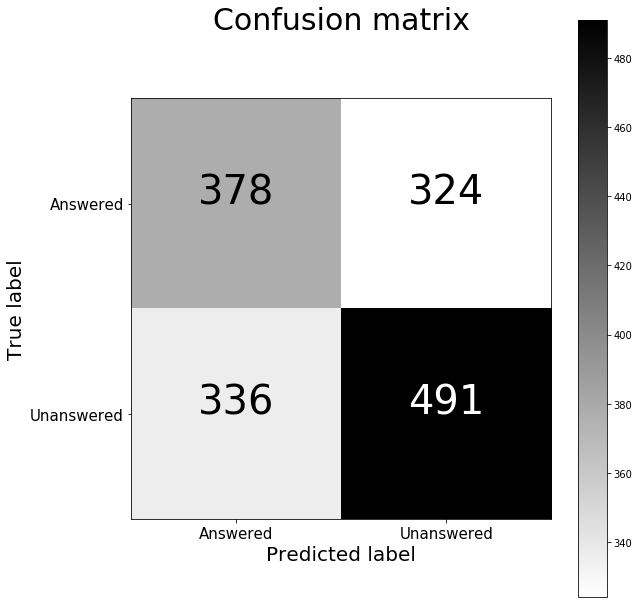

In [9]:
from model_evaluation import get_confusion_matrix_plot

get_confusion_matrix_plot(y_predicted, y_test, figsize=(9, 9))
plt.show()

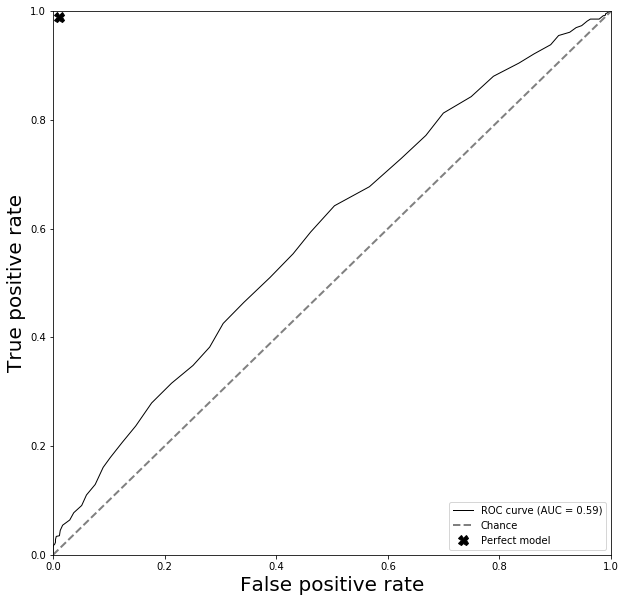

In [10]:
from model_evaluation import get_roc_plot

get_roc_plot(y_predicted_proba[:,1], y_test, figsize=(10,10))
plt.show()


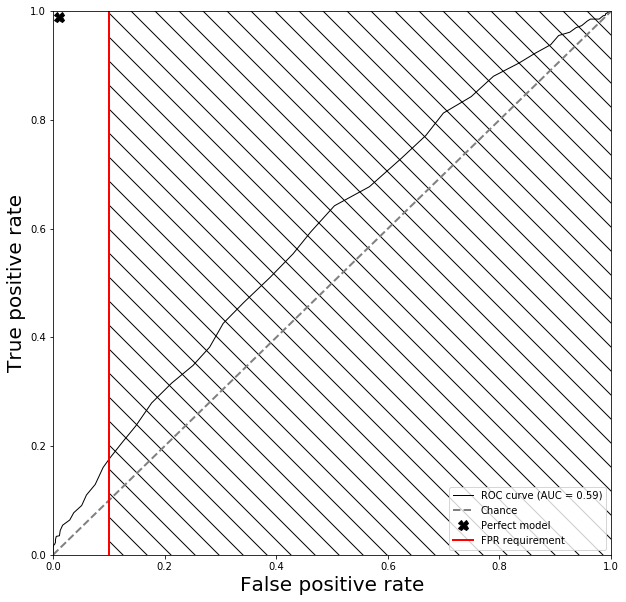

In [11]:
get_roc_plot(y_predicted_proba[:,1], y_test, fpr_bar=.1, figsize=(10,10))
plt.show()

No handles with labels found to put in legend.


	Brier: 0.242


<module 'matplotlib.pyplot' from '/Users/emmanuel.ameisen/ml_editor/lib/python3.6/site-packages/matplotlib/pyplot.py'>

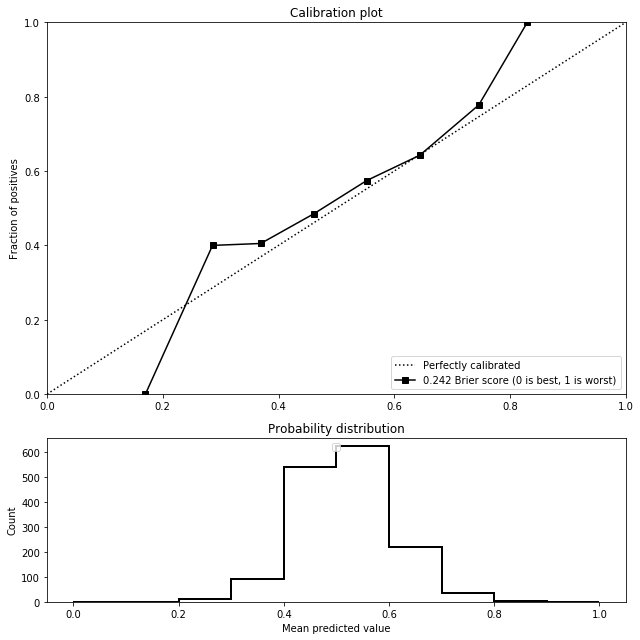

In [12]:
from model_evaluation import get_calibration_plot

get_calibration_plot(y_predicted_proba[:,1], y_test, figsize=(9,9))


In [13]:
from model_evaluation import get_feature_importance

feature_names = [
    "action_verb_full",
    "question_mark_full",
    "norm_text_len",
    "language_question",
]

w_indices = ["word_vector_index_%s" % s for s in range(300)]
w_indices.extend(feature_names)
all_feature_names = np.array(w_indices)



In [14]:

print("Top 5 importances:\n")
print('\n'.join(["%s: %.2g" % (tup[0], tup[1]) for tup in get_feature_importance(clf, all_feature_names)[:5]]))

print("\nBottom 5 importances:\n")
print('\n'.join(["%s: %.2g" % (tup[0], tup[1]) for tup in get_feature_importance(clf, all_feature_names)[-5:]]))

Top 5 importances:

norm_text_len: 0.0058
word_vector_index_160: 0.0053
word_vector_index_273: 0.0047
word_vector_index_162: 0.0047
word_vector_index_256: 0.0042

Bottom 5 importances:

word_vector_index_180: 0.0026
word_vector_index_76: 0.0026
question_mark_full: 0.00023
action_verb_full: 0.00022
language_question: 0.00013


## Let's look at most and least successful examples

In [17]:
from model_evaluation import get_top_k
test_analysis_df = test_df.copy()
test_analysis_df["predicted_proba"] = y_predicted_proba[:, 1]
test_analysis_df["true_label"] = y_test

to_display = [
    "predicted_proba",
    "true_label",
    "Title",
    "body_text",
    "text_len",
    "action_verb_full",
    "question_mark_full",
    "language_question",
]
threshold = 0.5


top_pos, top_neg, worst_pos, worst_neg, unsure = get_top_k(test_analysis_df, "predicted_proba", "true_label", k=2)
pd.options.display.max_colwidth = 100

In [18]:
# Most confident correct positive predictions
top_pos[to_display]

,predicted_proba,true_label,Title,body_text,text_len,action_verb_full,question_mark_full,language_question
Id,,,,,,,,
39327,0.83,True,How to write female characters as a male writer?,Yesterday I asked a question about writing a female character who has agency. Much to my surpri...,890,True,True,False
39740,0.80,True,Facial expressions as part of dialogue - getting rid of a verbal tic,I noticed a verbal tic in my writing:\n\nHe looked surprised\nHe looked confused\nHe looked abas...,261,True,True,False


In [19]:
# Most confident correct negative predictions
top_neg[to_display]

,predicted_proba,true_label,Title,body_text,text_len,action_verb_full,question_mark_full,language_question
Id,,,,,,,,
7878,0.17,False,"When quoting a person's informal speech, how much liberty do you have to make changes to what th...","Even during a formal interview for a news article, people speak informally. They say ""uhm"", they...",116,True,True,False
29462,0.27,False,How to protect my idea/design to re-publish a public domain book?,I found a public domain book that has never been re-published and I wanted to include illustrati...,89,True,True,False


In [20]:
# Most confident incorrect negative predictions
worst_pos[to_display]

,predicted_proba,true_label,Title,body_text,text_len,action_verb_full,question_mark_full,language_question
Id,,,,,,,,
18613,0.24,True,"Addressing ""logo-ification"" of an organization's name in their literature",I need help finding some style rules to address an issue with a client. I'm working with an orga...,230,False,True,False
6307,0.27,True,Path to publishing a technical book,I'm 21 years old female from South India. I would like to publish a book which concentrates on a...,99,True,True,False


In [21]:
# Most confident incorrect positive predictions
worst_neg[to_display]

,predicted_proba,true_label,Title,body_text,text_len,action_verb_full,question_mark_full,language_question
Id,,,,,,,,
28830,0.76,False,Is it okay to have made up words/slang in a story?,"In my story there are some words in there that even Grammarly couldn't understand, but they make...",249,False,True,False
4107,0.75,False,Single character POV vs. two POVs - how to decide?,"I'm starting to look at my next novel, and I'm trying to decide whether I should tell it from on...",281,True,True,False


In [24]:
# Most unsure questions
unsure[to_display]

,predicted_proba,true_label,Title,body_text,text_len,action_verb_full,question_mark_full,language_question
Id,,,,,,,,
1,0.5,True,What are some online guides for starting writers?,"I've always wanted to start writing (in a totally amateur way), but whenever I want to start som...",61,True,True,False
33439,0.5,True,"Prepare for more after the ""ending""?","In my story, there's this big bad, who needs to be destroyed. That is the main goal for about th...",732,True,True,False


In [30]:
import spacy
from lime.lime_text import LimeTextExplainer

# Load a large model, and disable pipeline unnecessary parts for our task
# This speeds up the vectorization process significantly
# See https://spacy.io/models/en#en_core_web_lg for details about the model
vector_store = spacy.load('en_core_web_lg', disable=["parser", "tagger", "ner", "textcat"])


clf_text_only = RandomForestClassifier(n_estimators=100, class_weight='balanced', oob_score=True)
X_train_text = np.vstack(train_df["full_text"].apply(lambda x: vector_store(x).vector))
X_test_text = np.vstack(test_df["full_text"].apply(lambda x: vector_store(x).vector))
clf_text_only.fit(X_train_text, y_train)

def text_pipeline(examples):
    global vector_store
    vectors = [vector_store(x).vector for x in examples]
    vectors=np.vstack(np.array(vectors))

    return clf_text_only.predict_proba(vectors)


In [31]:
def explain_one_instance(instance, class_names):
    explainer = LimeTextExplainer(class_names=class_names)
    exp = explainer.explain_instance(instance, text_pipeline, num_features=6)
    return exp

def visualize_one_exp(features, labels, index, class_names = ["Unanswered","Answered"]):
    exp = explain_one_instance(features[index], class_names = class_names)
    print('Index: %d' % index)
    print('True class: %s' % class_names[labels[index]])
    exp.show_in_notebook(text=True)

In [34]:
visualize_one_exp(list(test_df["full_text"]), list(y_test), 7)

/usr/local/Cellar/python/3.6.5_1/Frameworks/Python.framework/Versions/3.6/lib/python3.6/re.py:212: FutureWarning: split() requires a non-empty pattern match.
  return _compile(pattern, flags).split(string, maxsplit)


Index: 7
True class: Answered


In [35]:
import random
from collections import defaultdict

random.seed(40)

def get_statistical_explanation(test_set, sample_size, word2vec_pipeline, label_dict):
    sample_sentences = random.sample(test_set, sample_size)
    explainer = LimeTextExplainer()
    
    labels_to_sentences = defaultdict(list)
    contributors = defaultdict(dict)
    
    # First, find contributing words to each class
    for sentence in sample_sentences:
        probabilities = word2vec_pipeline([sentence])
        curr_label = probabilities[0].argmax()
        labels_to_sentences[curr_label].append(sentence)
        exp = explainer.explain_instance(sentence, word2vec_pipeline, num_features=6, labels=[curr_label])
        listed_explanation = exp.as_list(label=curr_label)
        
        for word,contributing_weight in listed_explanation:
            if word in contributors[curr_label]:
                contributors[curr_label][word].append(contributing_weight)
            else:
                contributors[curr_label][word] = [contributing_weight]    
    
    # average each word's contribution to a class, and sort them by impact
    average_contributions = {}
    sorted_contributions = {}
    for label,lexica in contributors.items():
        curr_label = label
        curr_lexica = lexica
        average_contributions[curr_label] = pd.Series(index=curr_lexica.keys())
        for word,scores in curr_lexica.items():
            average_contributions[curr_label].loc[word] = np.sum(np.array(scores))/sample_size
        detractors = average_contributions[curr_label].sort_values()
        supporters = average_contributions[curr_label].sort_values(ascending=False)
        sorted_contributions[label_dict[curr_label]] = {
            'detractors':detractors,
             'supporters': supporters
        }
    return sorted_contributions

label_to_text = {
    0: 'Unanswered',
    1: 'Answered',
}
sorted_contributions = get_statistical_explanation(list(test_df["full_text"]), 5, text_pipeline, label_to_text)



/usr/local/Cellar/python/3.6.5_1/Frameworks/Python.framework/Versions/3.6/lib/python3.6/re.py:212: FutureWarning: split() requires a non-empty pattern match.
  return _compile(pattern, flags).split(string, maxsplit)
/usr/local/Cellar/python/3.6.5_1/Frameworks/Python.framework/Versions/3.6/lib/python3.6/re.py:212: FutureWarning: split() requires a non-empty pattern match.
  return _compile(pattern, flags).split(string, maxsplit)
/usr/local/Cellar/python/3.6.5_1/Frameworks/Python.framework/Versions/3.6/lib/python3.6/re.py:212: FutureWarning: split() requires a non-empty pattern match.
  return _compile(pattern, flags).split(string, maxsplit)
/usr/local/Cellar/python/3.6.5_1/Frameworks/Python.framework/Versions/3.6/lib/python3.6/re.py:212: FutureWarning: split() requires a non-empty pattern match.
  return _compile(pattern, flags).split(string, maxsplit)
/usr/local/Cellar/python/3.6.5_1/Frameworks/Python.framework/Versions/3.6/lib/python3.6/re.py:212: FutureWarning: split() requires a non

In [36]:
def plot_important_words(top_scores, top_words, bottom_scores, bottom_words, name):
    y_pos = np.arange(len(top_words))
    top_pairs = [(a,b) for a,b in zip(top_words, top_scores)]
    top_pairs = sorted(top_pairs, key=lambda x: x[1])
    
    bottom_pairs = [(a,b) for a,b in zip(bottom_words, bottom_scores)]
    bottom_pairs = sorted(bottom_pairs, key=lambda x: x[1], reverse=True)
    
    top_words = [a[0] for a in top_pairs]
    top_scores = [a[1] for a in top_pairs]
    
    bottom_words = [a[0] for a in bottom_pairs]
    bottom_scores = [a[1] for a in bottom_pairs]
    
    fig = plt.figure(figsize=(10, 10))  

    plt.subplot(121)
    plt.barh(y_pos,bottom_scores, align='center', alpha=0.5)
    plt.title('Unanswered', fontsize=20)
    plt.yticks(y_pos, bottom_words, fontsize=14)
    plt.suptitle('Key words', fontsize=16)
    plt.xlabel('Importance', fontsize=20)
    
    plt.subplot(122)
    plt.barh(y_pos,top_scores, align='center', alpha=0.5)
    plt.title('Answered', fontsize=20)
    plt.yticks(y_pos, top_words, fontsize=14)
    plt.suptitle(name, fontsize=16)
    plt.xlabel('Importance', fontsize=20)
    
    plt.subplots_adjust(wspace=0.8)
    plt.show()

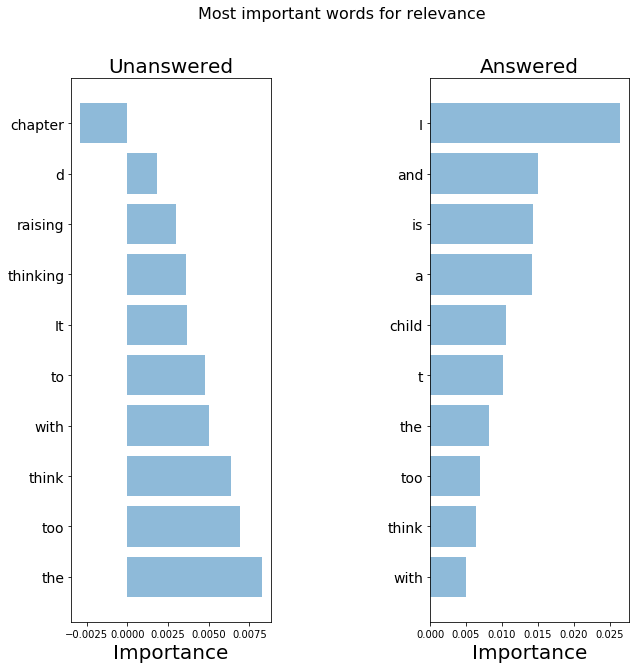

In [37]:
top_words = sorted_contributions['Answered']['supporters'][:10].index.tolist()
top_scores = sorted_contributions['Answered']['supporters'][:10].tolist()
bottom_words = sorted_contributions['Answered']['detractors'][:10].index.tolist()
bottom_scores = sorted_contributions['Answered']['detractors'][:10].tolist()

plot_important_words(top_scores, top_words, bottom_scores, bottom_words, "Most important words for relevance")

Training accuracy = 0.561, precision = 0.561, recall = 0.561, f1 = 0.561
Validation accuracy = 0.574, precision = 0.573, recall = 0.574, f1 = 0.573


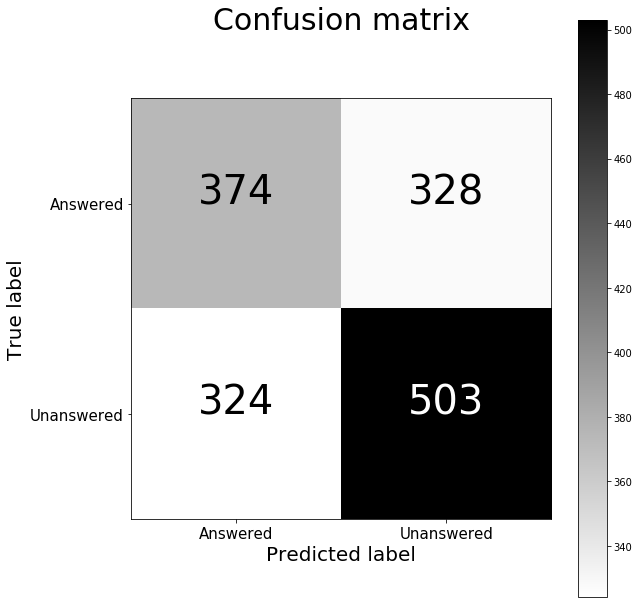

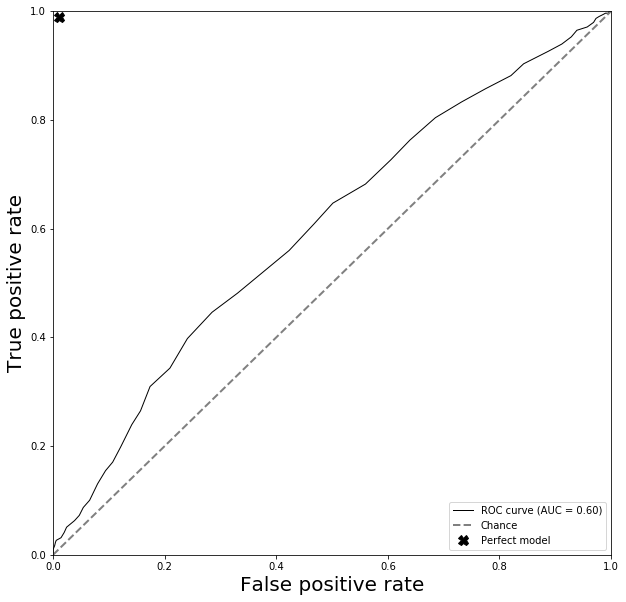

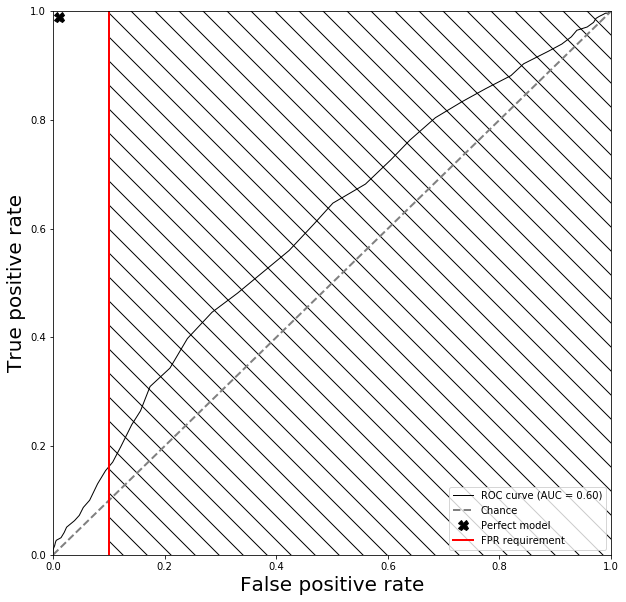

No handles with labels found to put in legend.


	Brier: 0.242
Top 5 importances:

norm_text_len: 0.0062
word_vector_index_160: 0.0048
word_vector_index_232: 0.0047
word_vector_index_162: 0.0046
word_vector_index_46: 0.0045

Bottom 5 importances:

word_vector_index_226: 0.0025
word_vector_index_283: 0.0024
action_verb_full: 0.00032
question_mark_full: 0.00031
language_question: 0.00012


/usr/local/Cellar/python/3.6.5_1/Frameworks/Python.framework/Versions/3.6/lib/python3.6/re.py:212: FutureWarning: split() requires a non-empty pattern match.
  return _compile(pattern, flags).split(string, maxsplit)


Index: 7
True class: Answered


/usr/local/Cellar/python/3.6.5_1/Frameworks/Python.framework/Versions/3.6/lib/python3.6/re.py:212: FutureWarning: split() requires a non-empty pattern match.
  return _compile(pattern, flags).split(string, maxsplit)
/usr/local/Cellar/python/3.6.5_1/Frameworks/Python.framework/Versions/3.6/lib/python3.6/re.py:212: FutureWarning: split() requires a non-empty pattern match.
  return _compile(pattern, flags).split(string, maxsplit)
/usr/local/Cellar/python/3.6.5_1/Frameworks/Python.framework/Versions/3.6/lib/python3.6/re.py:212: FutureWarning: split() requires a non-empty pattern match.
  return _compile(pattern, flags).split(string, maxsplit)
/usr/local/Cellar/python/3.6.5_1/Frameworks/Python.framework/Versions/3.6/lib/python3.6/re.py:212: FutureWarning: split() requires a non-empty pattern match.
  return _compile(pattern, flags).split(string, maxsplit)
/usr/local/Cellar/python/3.6.5_1/Frameworks/Python.framework/Versions/3.6/lib/python3.6/re.py:212: FutureWarning: split() requires a non

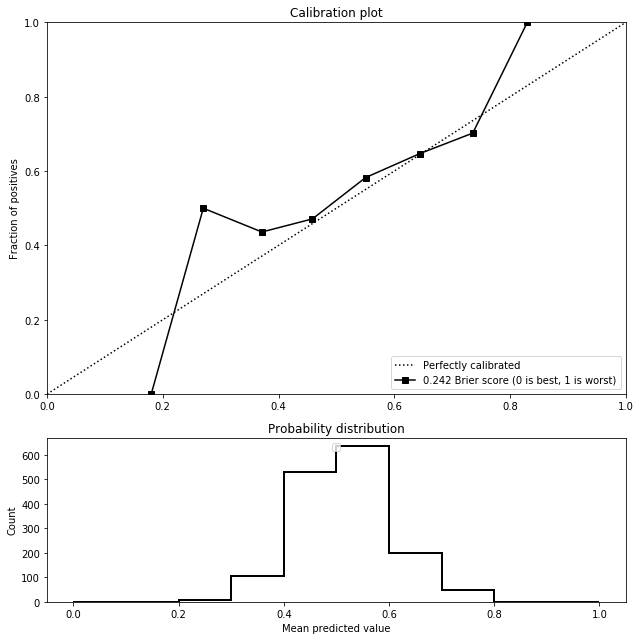

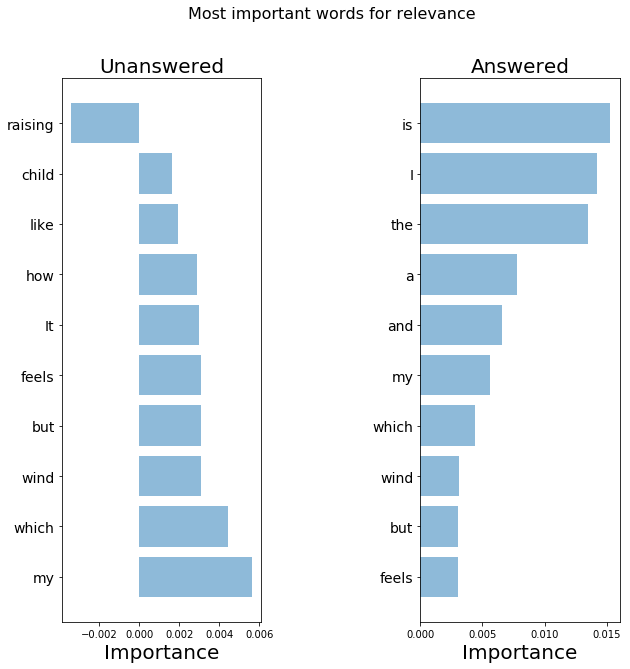

In [38]:
## Let's try a simple model

X_train, y_train = get_vectorized_inputs_and_label(train_df)

X_test, y_test = get_vectorized_inputs_and_label(test_df)

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=100, class_weight='balanced', oob_score=True)
clf.fit(X_train, y_train)

y_predicted = clf.predict(X_test)
y_predicted_proba = clf.predict_proba(X_test)

y_train.value_counts()

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report

def get_metrics(y_test, y_predicted):  
    # true positives / (true positives+false positives)
    precision = precision_score(y_test, y_predicted, pos_label=None,
                                    average='weighted')             
    # true positives / (true positives + false negatives)
    recall = recall_score(y_test, y_predicted, pos_label=None,
                              average='weighted')
    
    # harmonic mean of precision and recall
    f1 = f1_score(y_test, y_predicted, pos_label=None, average='weighted')
    
    # true positives + true negatives/ total
    accuracy = accuracy_score(y_test, y_predicted)
    return accuracy, precision, recall, f1



# Training accuracy
# Thanks to https://datascience.stackexchange.com/questions/13151/randomforestclassifier-oob-scoring-method
y_train_pred = np.argmax(clf.oob_decision_function_,axis=1)

accuracy, precision, recall, f1 = get_metrics(y_train, y_train_pred)
print("Training accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy, precision, recall, f1))

accuracy, precision, recall, f1 = get_metrics(y_test, y_predicted)
print("Validation accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy, precision, recall, f1))

from model_evaluation import get_confusion_matrix_plot

get_confusion_matrix_plot(y_predicted, y_test, figsize=(9, 9))
plt.show()

from model_evaluation import get_roc_plot

get_roc_plot(y_predicted_proba[:,1], y_test, figsize=(10,10))
plt.show()


get_roc_plot(y_predicted_proba[:,1], y_test, fpr_bar=.1, figsize=(10,10))
plt.show()

from model_evaluation import get_calibration_plot

get_calibration_plot(y_predicted_proba[:,1], y_test, figsize=(9,9))


from model_evaluation import get_feature_importance

feature_names = [
    "action_verb_full",
    "question_mark_full",
    "norm_text_len",
    "language_question",
]

w_indices = ["word_vector_index_%s" % s for s in range(300)]
w_indices.extend(feature_names)
all_feature_names = np.array(w_indices)




print("Top 5 importances:\n")
print('\n'.join(["%s: %.2g" % (tup[0], tup[1]) for tup in get_feature_importance(clf, all_feature_names)[:5]]))

print("\nBottom 5 importances:\n")
print('\n'.join(["%s: %.2g" % (tup[0], tup[1]) for tup in get_feature_importance(clf, all_feature_names)[-5:]]))

## Let's look at most and least successful examples

from model_evaluation import get_top_k
test_analysis_df = test_df.copy()
test_analysis_df["predicted_proba"] = y_predicted_proba[:, 1]
test_analysis_df["true_label"] = y_test

to_display = [
    "predicted_proba",
    "true_label",
    "Title",
    "body_text",
    "text_len",
    "action_verb_full",
    "question_mark_full",
    "language_question",
]
threshold = 0.5


top_pos, top_neg, worst_pos, worst_neg, unsure = get_top_k(test_analysis_df, "predicted_proba", "true_label", k=2)
pd.options.display.max_colwidth = 100

# Most confident correct positive predictions
top_pos[to_display]

# Most confident correct negative predictions
top_neg[to_display]

# Most confident incorrect negative predictions
worst_pos[to_display]

# Most confident incorrect positive predictions
worst_neg[to_display]

# Most unsure questions
unsure[to_display]

from lime.lime_text import LimeTextExplainer

clf_text_only = RandomForestClassifier(n_estimators=100, class_weight='balanced', oob_score=True)
X_train_text = np.vstack(train_df["full_text"].apply(lambda x: vector_store(x).vector))
X_test_text = np.vstack(test_df["full_text"].apply(lambda x: vector_store(x).vector))
clf_text_only.fit(X_train_text, y_train)

def text_pipeline(examples):
    global vector_store
    vectors = [vector_store(x).vector for x in examples]
    vectors=np.vstack(np.array(vectors))

    return clf_text_only.predict_proba(vectors)


def explain_one_instance(instance, class_names):
    explainer = LimeTextExplainer(class_names=class_names)
    exp = explainer.explain_instance(instance, text_pipeline, num_features=6)
    return exp

def visualize_one_exp(features, labels, index, class_names = ["Unanswered","Answered"]):
    exp = explain_one_instance(features[index], class_names = class_names)
    print('Index: %d' % index)
    print('True class: %s' % class_names[labels[index]])
    exp.show_in_notebook(text=True)

visualize_one_exp(list(test_df["full_text"]), list(y_test), 7)

import random
from collections import defaultdict

random.seed(40)

def get_statistical_explanation(test_set, sample_size, word2vec_pipeline, label_dict):
    sample_sentences = random.sample(test_set, sample_size)
    explainer = LimeTextExplainer()
    
    labels_to_sentences = defaultdict(list)
    contributors = defaultdict(dict)
    
    # First, find contributing words to each class
    for sentence in sample_sentences:
        probabilities = word2vec_pipeline([sentence])
        curr_label = probabilities[0].argmax()
        labels_to_sentences[curr_label].append(sentence)
        exp = explainer.explain_instance(sentence, word2vec_pipeline, num_features=6, labels=[curr_label])
        listed_explanation = exp.as_list(label=curr_label)
        
        for word,contributing_weight in listed_explanation:
            if word in contributors[curr_label]:
                contributors[curr_label][word].append(contributing_weight)
            else:
                contributors[curr_label][word] = [contributing_weight]    
    
    # average each word's contribution to a class, and sort them by impact
    average_contributions = {}
    sorted_contributions = {}
    for label,lexica in contributors.items():
        curr_label = label
        curr_lexica = lexica
        average_contributions[curr_label] = pd.Series(index=curr_lexica.keys())
        for word,scores in curr_lexica.items():
            average_contributions[curr_label].loc[word] = np.sum(np.array(scores))/sample_size
        detractors = average_contributions[curr_label].sort_values()
        supporters = average_contributions[curr_label].sort_values(ascending=False)
        sorted_contributions[label_dict[curr_label]] = {
            'detractors':detractors,
             'supporters': supporters
        }
    return sorted_contributions

label_to_text = {
    0: 'Unanswered',
    1: 'Answered',
}
sorted_contributions = get_statistical_explanation(list(test_df["full_text"]), 5, text_pipeline, label_to_text)



def plot_important_words(top_scores, top_words, bottom_scores, bottom_words, name):
    y_pos = np.arange(len(top_words))
    top_pairs = [(a,b) for a,b in zip(top_words, top_scores)]
    top_pairs = sorted(top_pairs, key=lambda x: x[1])
    
    bottom_pairs = [(a,b) for a,b in zip(bottom_words, bottom_scores)]
    bottom_pairs = sorted(bottom_pairs, key=lambda x: x[1], reverse=True)
    
    top_words = [a[0] for a in top_pairs]
    top_scores = [a[1] for a in top_pairs]
    
    bottom_words = [a[0] for a in bottom_pairs]
    bottom_scores = [a[1] for a in bottom_pairs]
    
    fig = plt.figure(figsize=(10, 10))  

    plt.subplot(121)
    plt.barh(y_pos,bottom_scores, align='center', alpha=0.5)
    plt.title('Unanswered', fontsize=20)
    plt.yticks(y_pos, bottom_words, fontsize=14)
    plt.suptitle('Key words', fontsize=16)
    plt.xlabel('Importance', fontsize=20)
    
    plt.subplot(122)
    plt.barh(y_pos,top_scores, align='center', alpha=0.5)
    plt.title('Answered', fontsize=20)
    plt.yticks(y_pos, top_words, fontsize=14)
    plt.suptitle(name, fontsize=16)
    plt.xlabel('Importance', fontsize=20)
    
    plt.subplots_adjust(wspace=0.8)
    plt.show()

top_words = sorted_contributions['Answered']['supporters'][:10].index.tolist()
top_scores = sorted_contributions['Answered']['supporters'][:10].tolist()
bottom_words = sorted_contributions['Answered']['detractors'][:10].index.tolist()
bottom_scores = sorted_contributions['Answered']['detractors'][:10].tolist()

plot_important_words(top_scores, top_words, bottom_scores, bottom_words, "Most important words for relevance")